### Machine-Learning Asset Allocation

Most of the functions below can be found under:

* Portfolio_opt/**

This exercise is more about portfolio optimization and asset-allocation using ML.

There are quite a number of monte-carlos simulation.

If this chapter doesn't blow up your mind.. it's probably going to blow up your com.

The focused portfolio management style will be Hierarchical Risk Parity (HRP), but comparison will be made to Critical Line Agorithm (CLA) approach as well as Inverse-Variance approach (IVP).

3 different quantitative portfolio management style to which how systematic and idiosyncratic risk are managed. (Bottom up/ Top down approach)

**Warning**

Save your notebook often for this chapter. Infinite loops is highly likely if you are not careful.

If you are keen on generating synthetic data for your research, copy the code snippets [Generate synthetic raw data](https://gist.github.com/boyboi86/5e00faf48f60abfdbe838fbdee269471) in my gist.

Additional resource: 
* [Critical Line Aglorithm](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2197616)
* [EF Robust Estimator](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3469961)

Contact: boyboi86@gmail.com

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import research as rs
from scipy.cluster.hierarchy import dendrogram, linkage, fclusterdata
from scipy.spatial.distance import pdist, squareform
import random

%matplotlib inline

Num of CPU core:  4
Machine info:  Windows-10-10.0.18362-SP0
Python 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Numpy 1.18.5
Pandas 1.0.4


In [2]:
def quasi_diag(link):
    link = link.astype(int)
    sort_idx = pd.Series([link[-1,0], link[-1,1]])
    n_items = link[-1,3]
    while sort_idx.max() >= n_items:
        sort_idx.index = np.arange(0, sort_idx.shape[0] * 2, 2)
        df0 = sort_idx[sort_idx>=n_items]
        i = df0.index
        j = df0.values - n_items
        sort_idx[i] = link[j,0]
        df0 = pd.Series(link[j,1], index = i+1)
        sort_idx = sort_idx.append(df0)
        sort_idx = sort_idx.sort_index()
        sort_idx.index = np.arange(sort_idx.shape[0])
    return sort_idx.tolist()

def seriation(Z, N, cur_index):
    """Returns the order implied by a hierarchical tree (dendrogram).
    
       :param Z: A hierarchical tree (dendrogram).
       :param N: The number of points given to the clustering process.
       :param cur_index: The position in the tree for the recursive traversal.
       
       :return: The order implied by the hierarchical tree Z.
    """
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index - N, 0])
        right = int(Z[cur_index - N, 1])
        return (seriation(Z, N, left) + seriation(Z, N, right))

    
def compute_serial_matrix(dist_mat, method="single"):
    """Returns a sorted distance matrix.
    
       :param dist_mat: A distance matrix.
       :param method: A string in ["ward", "single", "average", "complete"].
        
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    """
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N - 2)
    seriated_dist = np.zeros((N, N))
    a,b = np.triu_indices(N, k=1)
    seriated_dist[a,b] = dist_mat[[res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

def IVP(cov, **kwarg):
    ivp = 1./np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def corr_dist(corr):
    #dist = ((1-corr)/2.) ** .5
    dist = np.sqrt((1 - corr) / 2.)
    return dist

def corr_mtx_plot(corr: float, path: str = None, labels = None, title = None):
    plt.figure(figsize=(8,6))
    if labels is None: 
        labels = []
    plt.pcolor(corr)
    plt.colorbar()
    plt.yticks(np.arange(.5, corr.shape[0] + .5), labels)
    plt.xticks(np.arange(.5, corr.shape[0] + .5), labels)
    if path is not None:
        plt.savefig(path)
        plt.clf()
        plt.close()
    if title is not None:
        plt.title(title)
    plt.show()

def ddg_plot(link, labels = None):
    plt.figure(figsize=(8,6))
    dn = dendrogram(link,
                        labels = labels, #change label num count if you are increasing size
                        above_threshold_color='y',
                        orientation='top')
    
    plt.title("Dendogram of Cluster Formation")
    plt.show()   
    
def hrp(x: pd.DataFrame):
    
    cov, corr = x.cov(), x.corr()
    labels = np.arange(1,len(corr)+1)
    corr_mtx_plot(corr = corr, path = None, labels = None, title = "Original Covariance Matrix Heat-Map")
    dist = corr_dist(corr = corr)
    link = linkage(dist, 'single')
    ddg_plot(link = link, labels = labels)
    sort_idx = quasi_diag(link = link)
    sort_idx = corr.index[sort_idx].tolist()
    df0 = corr.loc[sort_idx, sort_idx]
    corr_mtx_plot(corr = df0, path = None, labels = df0.columns, title = "After Quasi-Diagonization")    

def cla(cov):
    if isinstance(cov, pd.DataFrame):
        cov = cov.to_numpy()
    mean = np.arange(1,cov.shape[0] +1).reshape(-1,1)
    lb = np.zeros(mean.shape)
    ub = np.ones(mean.shape)
    _cla = rs.CLA(mean, cov, lb, ub)
    _cla.solve()
    return _cla.w[-1].flatten()

**Note**

Before you go any further down, spend some time on these information I gathered.

They are casual and easy way to understand what we will be doing next. Unless you already know we are dealing with KNN Algorithm, otherwise please go to these links and watch the videos.

[Youtube Link: Flat and Hierarchical Clustering | The Dendrogram Explained](https://www.youtube.com/watch?v=ijUMKMC4f9I)

[Youtube LinkL K-Nearest Neighbour](https://www.youtube.com/watch?v=HVXime0nQeI)

**Note**

One of the video is really cheesy..

**Note**

It's important for any quant to understand what they are using to profit..

In [3]:
n_obs = 10000
size0 = 5
size1 = 10
sig1 = .25
seed = 12345

mtx = rs.generate_HRP_data(n_obs = n_obs,
                        size0 = size0,
                        size1 = size1,
                        sig1 = sig1,
                        seed = seed)

Dendogram based on the below grouping
[(4, 6), (1, 7), (3, 8), (3, 9), (2, 10), (3, 11), (5, 12), (4, 13), (2, 14), (3, 15)]


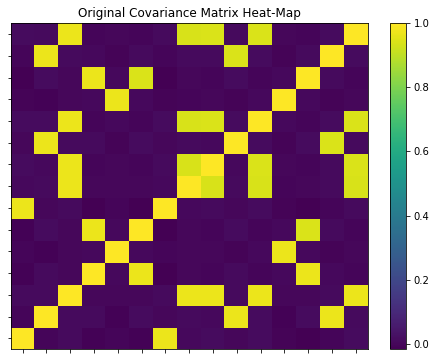

C:\Users\Wei_X\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


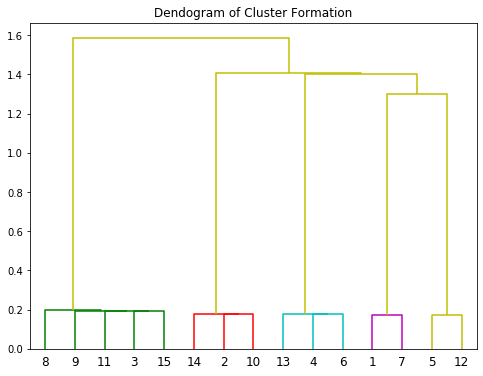

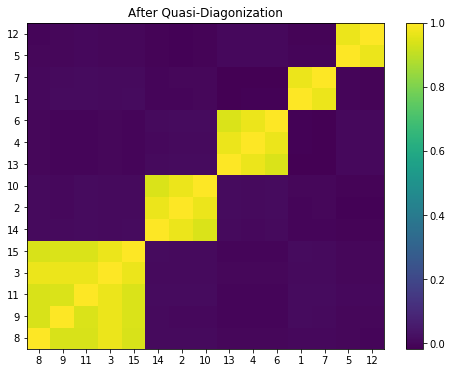

In [4]:
hrp = hrp(x = mtx)

# Either very strong corr or very weak (Yellow or dark purple)
# Sparse Matrix

**Note**

The below heatmaps and dendrograms are plotted based on daily return (original) against weekly returns.

**Note**

In order to use Hierarchical Risk Parity (HRP) portfolio management method.

Your portfolio needs to spread across entire investment universe (Equities, Bonds and alternatives). If assets are are too similar i.e. commodities ETF against commodities trading equities.

You might want to use CLA instead, since the amount that would be used in rebalance is insignificant. (It will still overweight some and give non-zero weight to the remaining)

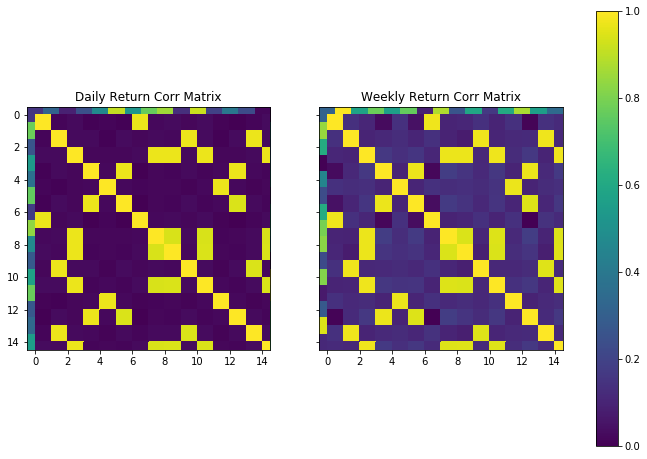

In [5]:
def sub_corr_mtx_plot(corr1: float, corr2:float):
    fig, axes = plt.subplots(1,2, figsize=(12,8), sharey = 'row',sharex='col')
    axes[0].pcolor(corr1)
    axes[1].pcolor(corr2)
    for ax in axes.flat:
        im = ax.imshow(np.random.random((len(corr1),len(corr1))), vmin=0, vmax=1)
    fig.colorbar(im, ax=axes.ravel().tolist())
    
    axes[0].title.set_text('Daily Return Corr Matrix')
    axes[1].title.set_text('Weekly Return Corr Matrix')
    plt.show()
    
def sub_ddg_plot(corr1, corr2):
    dist1 = corr_dist(corr = corr1)
    link1 = linkage(dist1, 'single')
    dist2 = corr_dist(corr = corr2)
    link2 = linkage(dist2, 'single')
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey = 'row',sharex='col')
    dn1 = dendrogram(link1, ax=axes[0], 
                     above_threshold_color='y',
                     labels = np.arange(1,len(corr1)+1),
                     orientation='top')
    dn2 = dendrogram(link2, ax=axes[1],
                        above_threshold_color='y',
                     labels = np.arange(1,len(corr2)+1),
                       orientation='top')
    
    axes[0].title.set_text('Daily Return Dendrogram')
    axes[1].title.set_text('Weekly Return Dendrogram')
    plt.show()

w_df = mtx.resample('W', axis = 0).mean() # resampled

sub_corr_mtx_plot(corr1 = mtx.corr(method='pearson'), corr2 = w_df.corr(method='pearson'))

**Note**

Notice the overall correlation matrix has changed.

Initially, we would have believed it was sparse. (Mostly dark purple shade)

After we resampled our data into weekly returns, now it became more "dense". (Most purple became lighter)

[Sparse Matrix Wiki Explanation](https://en.wikipedia.org/wiki/Sparse_matrix)

**Note**

Heatmaps portion that were originally yellow are still yellow.

**Note**

Perhapes it was due to the fact pnl was in small decimal places (1e-3).

Hence, when we try to "downsample", it became obvious which are the assets that does have valid correlations.

If they were really correlated, their mean result would be somewhat similar (Even when downsampled).

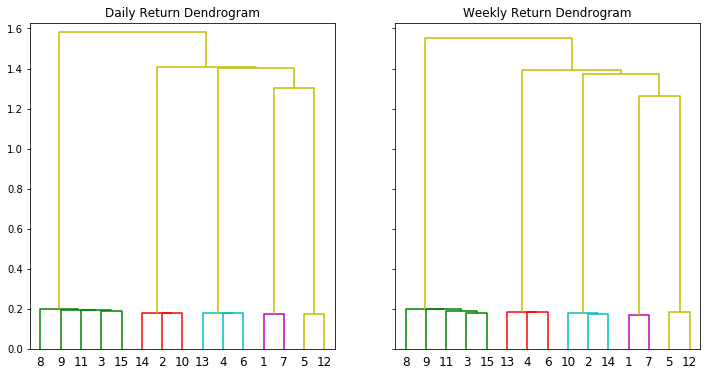

In [6]:
sub_ddg_plot(corr1 = np.corrcoef(mtx, rowvar = 0), corr2 = np.corrcoef(w_df, rowvar = 0))

**Note**

After we resampled into weekly average return the weekly return dendrogram displayed an obvious "classification" of these hierarchical clusters order.

There was a change in their distance; as a result 2 groups have changed their Hierarchy order:

* (14, 2, 10)
* (13, 4, 6)

The rest apart from changing their distance remained. (Increased from zero)

**Note**

We are using "single" method; minimal distance from each point.

Distance measure from right to left, bottom to top.

**Note**

The below bar chart represents asset weightage (Based on daily and weekly returns).

It would seem that because of the change, a drastic change in weight has occured between (13, 4, 6).

With Asset 13 being further, with Asset 6 becoming closer.

**Note**

Most of the asset allocation weights that were below the dotted line will "moderate" with heavier weights when using resampled weekly returns.

**Note**

Scipy Cluster Warning is related to the fact we are passing in a redundant matrix (Pandas cov() ). 

If you use numpy squareform to obtain a condense matrix, the Hierachy will no longer make sense.

Use the below numpy method instead to get correlation and set rowvar = 0.

    np.corrcoef()
    
[Numpy corrcoef()](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html#:~:text=Return%20Pearson%20product%2Dmoment%20correlation%20coefficients.&text=The%20values%20of%20R%20are%20between%20%2D1%20and%201%2C%20inclusive.&text=A%201%2DD%20or%202,containing%20multiple%20variables%20and%20observations.)

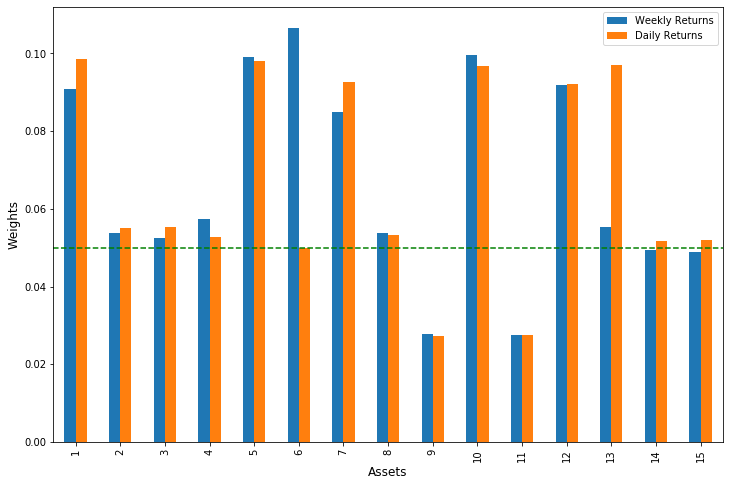

In [7]:
w_hrp = rs.HRP(data = w_df).solve(method = 'single')
d_hrp = rs.HRP(data = mtx).solve(method = 'single')

df_plot = pd.DataFrame({'Weekly Returns': w_hrp, 'Daily Returns': d_hrp})

df_plot.plot.bar(figsize=(12,8))
plt.ylabel("Weights", fontsize=12)
plt.xlabel("Assets", fontsize=12)
plt.axhline(y = 0.05, ls='--', c='g')
plt.show()

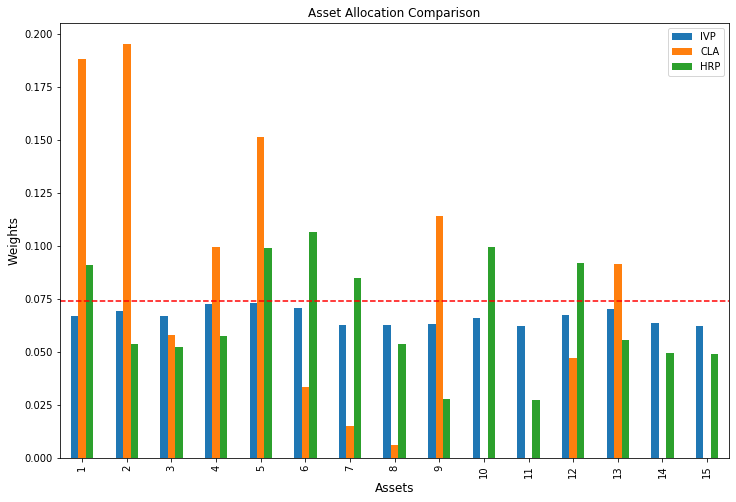

In [8]:
w_ivp = IVP(cov = w_df.cov())
w_clas = cla(cov = w_df.cov())

df1 = pd.DataFrame({'IVP':w_ivp, 'CLA': w_clas, 'HRP': w_hrp})

df1.plot.bar(figsize=(12,8))
plt.ylabel("Weights", fontsize=12)
plt.xlabel("Assets", fontsize=12)
plt.title("Asset Allocation Comparison")
plt.axhline(y=0.074, ls='--', c= 'r')
plt.show()

### Asset allocation comparison outcome

**Above red line:**
    
* Only Critical Line Algorithm (CLA) and Hierarchical Risk Parity (HRP) methods are present.
* Inverse Variance Parity (IVP) is totally absent.
* HRP and CLA has the close number of weightage above the red line (Estimated 5 - 6 in total).
* CLA usually provide the highest possible weight to a single asset among the 3 methods.
* However, HRP has rarely provides an asset allocation weightage more than CLA in any assets.
* CLA clearly provides a heavier weight than HRP method.

**Below the red line:**

* CLA weightage is absent from some of the assets allocation weightage.
* HRP and IVP are the only 2 methods that will provide a asset allocation weightage.
* IVP will always provide heavier weightage than HRP.

**Note**

Further analysis, HRP method will usually provide the second heaviest weight in all instances among the 3 methods or in some cases binary methods.


### Conclusion

IVP is distributing weight almost equally among all asset classes; this makes it susceptible to systematic risk.

CLA is distributing weight almost unequally among all asset classes; this makes it susceptible to idiosyncratic risk.

Only HRP will provide moderation which makes it the recommened method when it comes to portfolio rebalance and optimization.

**Personal Opinion**

If your 50% of your portfolio consist of ETFs or assets that were "already" diversified (No direct investment). CLA maybe a better choice.

If your portfolio is sector or asset-class focused. IVP maybe a better solution.

HRP requires a wide variety of direct investments to maximise it's potential. (Possible combination: Equities, Bonds, FX, Real-estate, Commodities)

So your AUM should be a sizable amount (Preferably x > USD 350 millions at least).

In [9]:
num = w_df.shape[1]
labels = np.arange(1, num + 1)

In [10]:
e_val, e_vec = np.linalg.eig(w_df.cov()) #to decompose

**Note**

[Eigen-decomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix)

In [11]:
e_matrix = np.identity(n=num) * e_val
e_df = pd.DataFrame(e_matrix, index = labels, columns = labels)
np.random.seed(0) # seed used!
eps = np.random.uniform(0, 1, size = num)
e_df = (num * eps * e_df * (sum(eps) **-1)) #based on formula

In [12]:
e_df1 = e_vec @ e_df @ np.linalg.inv(e_vec) #this is matrix do not use * to multiply
e_df1 = pd.DataFrame(e_df1)
e_df1.index = labels
e_df1.columns = labels

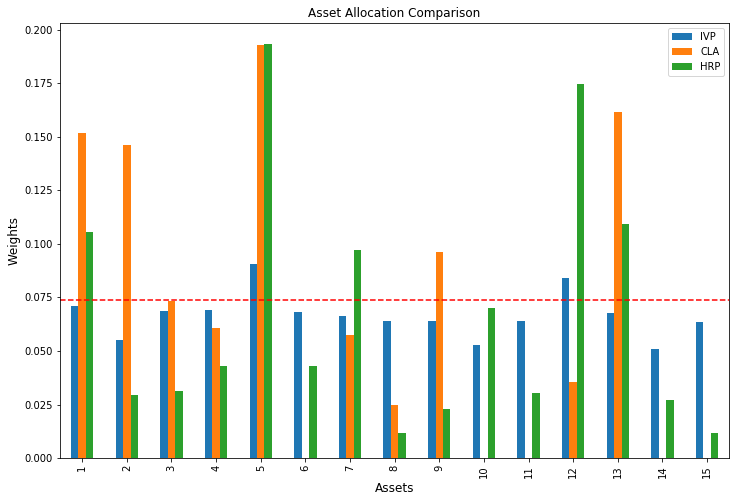

In [13]:
# Compare between 3 methods after decomposition

w_hrp1 = rs.HRP(data = e_df1).solve(method = 'single')
w_ivp1 = IVP(cov = e_df1)
w_clas1 = cla(cov = e_df1)

df2 = pd.DataFrame({'IVP': w_ivp1, 'CLA': w_clas1, 'HRP': w_hrp1})
df2.plot.bar(figsize=(12,8))
plt.ylabel("Weights", fontsize=12)
plt.xlabel("Assets", fontsize=12)
plt.title("Asset Allocation Comparison")
plt.axhline(y=0.074, ls='--', c= 'r')
plt.show()

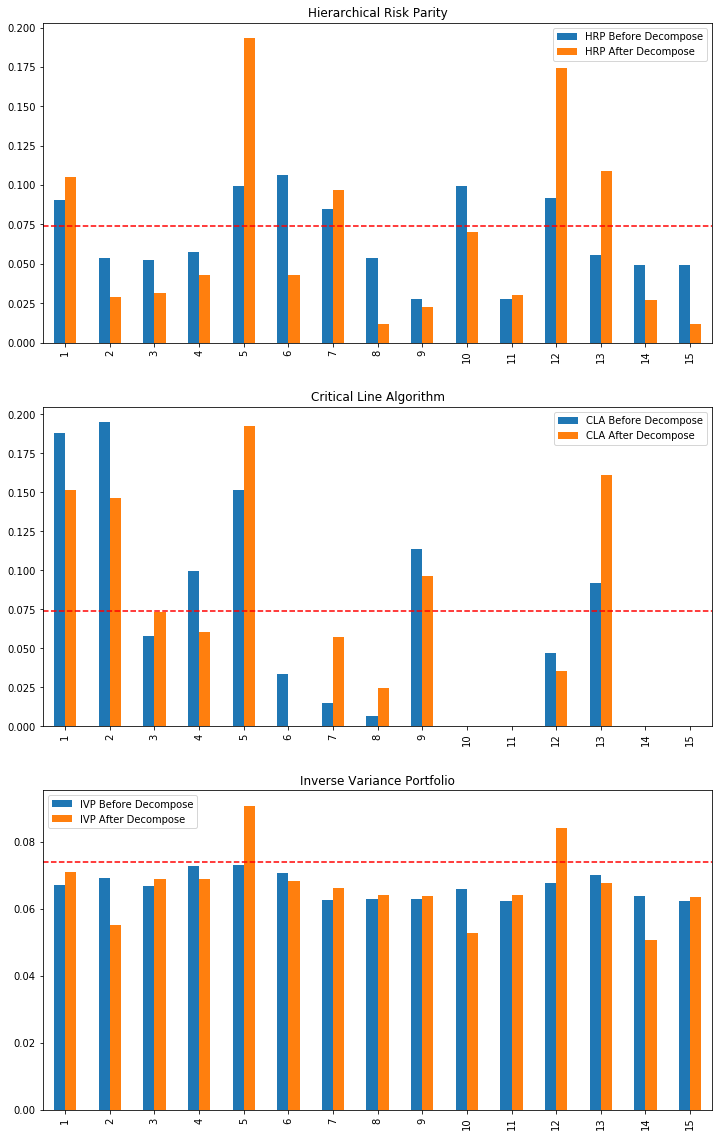

In [14]:
#Comparing before and after decomposition

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,20))
df_hrp = pd.DataFrame({'HRP Before Decompose': w_hrp, 'HRP After Decompose': w_hrp1})
df_cla = pd.DataFrame({'CLA Before Decompose': w_clas, 'CLA After Decompose': w_clas1})
df_cla.index = labels
df_ivp = pd.DataFrame({'IVP Before Decompose': w_ivp, 'IVP After Decompose': w_ivp1})
df_ivp.index = labels
df_hrp.plot.bar(ax = axes[0])
df_cla.plot.bar(ax = axes[1])
df_ivp.plot.bar(ax = axes[2])

axes[0].axhline(y=0.074, ls='--', c= 'r')
axes[0].set_title('Hierarchical Risk Parity')
axes[1].axhline(y=0.074, ls='--', c= 'r')
axes[1].set_title('Critical Line Algorithm')
axes[2].axhline(y=0.074, ls='--', c= 'r')
axes[2].set_title('Inverse Variance Portfolio')
plt.show()

### Asset allocation based on new covariance matrix

**Using the red line as benchmark:**

CLA: Some change in allocation was notice, however most of the assets that were above the red line before are still present. Some reduction and improvement in allocation is noticed.

IVP: Outcome is similar to CLA, but there are some changes that was also reflected in HRP. (Assets that have higher allocation in HRP also seen an increase in IVP)

HRP: Drastic shift in asset allocation, some assets that were previously above red line are currently below. Those that were below are now above. (Reflect in a big shift in asset allocation)

**Note**

Most change observed in HRP followed by IVP. The change in allocation seems unanimous across all 3 methods, just difference in magnitude.

**Note**

Notice Asset 5 and 12 which in accordance to the hierachy cluster seems to be the above threshold (Yellow color in dendrogram), reflects a change in their allocation. The other asset classes for HRP reflect the "distance" correctly after the eigen-decomposition.

The first group which consist of asset 3, 8, 9, 11, 15. Experience an overall lower allocation.

C:\Users\Wei_X\Desktop\Python\research\Portfolio_opt\hrp.py:31: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(y = dist, method = method, metric='euclidean')


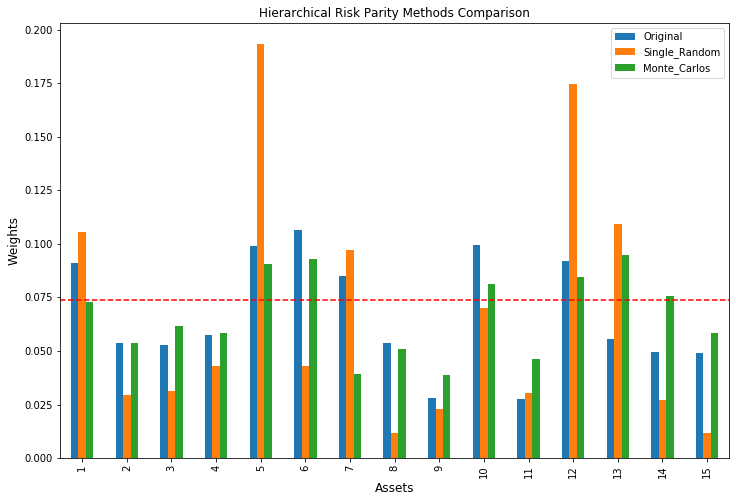

In [15]:
hrp_df = rs.HRP(data = w_df).rescale_solve(method = 'single',
                                           n_run = 100,
                                           long_only = True) #Monte-Carlos based on my algo

hrp_mc = pd.DataFrame(index=hrp_df.index).assign(Original = w_hrp, 
                                                 Single_Random = w_hrp1, 
                                                 Monte_Carlos = hrp_df)
hrp_mc.plot.bar(figsize=(12,8))
plt.ylabel("Weights", fontsize=12)
plt.xlabel("Assets", fontsize=12)
plt.axhline(y = 0.074, ls='--', c='r')
plt.title("Hierarchical Risk Parity Methods Comparison")
plt.show()

**Note**

The above method was based on Monte-Carlos Simulation plotted against the original weekly returns and single random decomposed covariance matrix.

Based on monte-carlos method, the weightage seems more moderated and the "correct" Hierarchical cluster weightage is also intact.

The original number of assets above the red dotted line should be the same as the number of assets above dotted red line above threshold (Othewise try increasing your Monte-Carlos runs).

Monte-Carlos simulation will always provide the "correct" mean in terms of weightage. However, to ensure the allocation is correct, it would be preferred to run about 10,000 times.

**Note**

The rescaling is to ensure that co-relation is minimized as much as possible. To ensure accuracy, HRP rescale should employ monte-carlo simulation.

**Note**

Do not perform convexity optimization for HRP, linkage method already "optimized" by minimizing the distance.

Convexity optimization is for IVP, which require more than just a normal "CAPM optimization".

It probably requires trinomial expansion as well. 

**Note**

In case if you have not notice, it will take some time to run this process. Do not worry.

In view of exchange regulations, once the recommended allocation is produced, it will still take time to unload or accumulate your positions.

To ensure your portfolio's profitability, do not perform direct investment more than certain threshold so that it would be easier to unload or accumulate any positions.

**Note**

The next section covers zero-sum hedge method (Allocation equals to zero), throughout the whole exercise we are only dealing with long-only portfolio.

Before that, you will need to go through this [presentation slide](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3512994)

Zero-sum hedge would require long-short portfolio method.

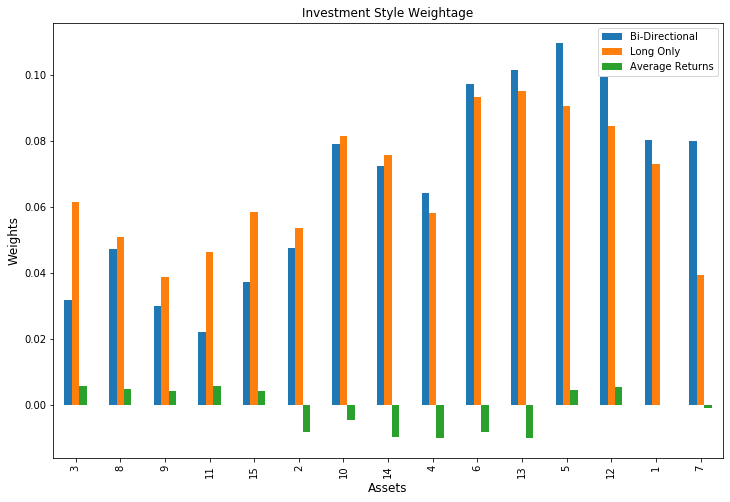

In [16]:
t_cluster = e_df1.mean(axis=0).quantile(q = 0.9) #as an estimate set quartile 0.9

c_grp = fclusterdata(X = e_df1, #based on eign-matrix
                     t = t_cluster, #based on eign-matrix
                     criterion='distance', 
                     metric='euclidean', 
                     depth=2, 
                     method='single', 
                     R=None)

hrp_df1 = rs.HRP(data = w_df).rescale_solve(method = 'single',
                                            n_run = 100,
                                            long_only = False)
hrp_df1['Long Only'] = hrp_df
hrp_df1['Average Returns'] = w_df.mean(axis = 0)

hrp_df1['grp'] = c_grp
grp_df= hrp_df1.sort_values(by='grp')
grp_df.rename(columns={"weights": "Bi-Directional"}).drop(columns = ["grp"]).plot.bar(figsize=(12,8))
plt.title("Investment Style Weightage")
plt.ylabel("Weights", fontsize=12)
plt.xlabel("Assets", fontsize=12)
plt.show()

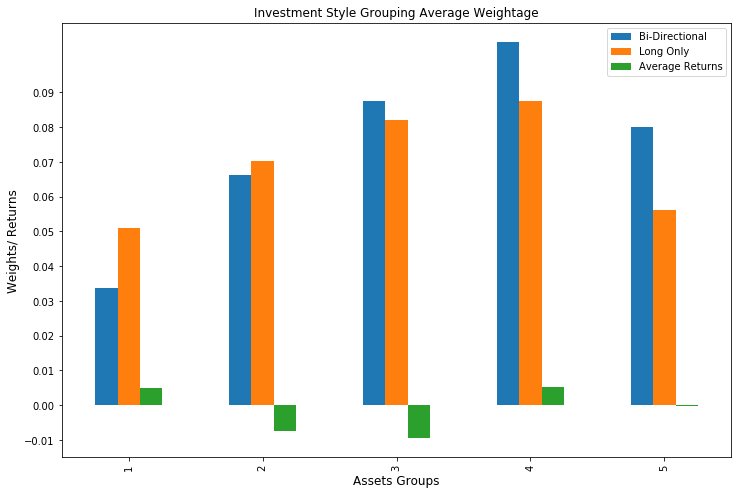

In [17]:
grp_df.rename(columns={"weights": "Bi-Directional"}).groupby("grp").mean().plot.bar(figsize=(12,8))
plt.title("Investment Style Grouping Average Weightage")
plt.ylabel("Weights/ Returns", fontsize=12)
plt.yticks(np.arange(-0.01, 0.1, step = 0.01))
plt.xlabel("Assets Groups", fontsize=12)
plt.show()

### Long vs bi-directional portfolio

**Based on grouped individual asset bar chart**

There is an obvious descending asset weightage trend (right to left), for both bi-directionl and long only portfolio.

As long as returns were positive in the observed order (Long-portfolio), HRP tends to give heavier weightage.

For bi-directional portfolio (Long/ short), it ignores the direction but rather focus on height of return bars. (Longer bar equals to higher allocation).

**Based on the asset group average weight bar chart**

Last group which is group 5 (Consist of [1, 7]), tends to enjoy higher weights while first group (Consist of [3, 8, 9, 11, 15]) then to have lower "averaged out" weights.

If it wasn't the fact that last group has negative returns, the long method would probably assign greater weight to it.

For long method, eventually most remaining weights were given to the first group.

While for long/ short method (blue bars), it is obvious weights were assigned based on magnitude/ height of return bars (Until exhausted). Rather than directions.

The deviation for both methods are minimal based on the above asset group graph.

**Note**

Each group is assumed to be different asset type or class. This is based on pearson's correlation recommendation.

Hence to avoid clash between theories, we will use bi-directional portfolio to complete zero-sum hedge.

The key idea is to ensure full-diversification across asset classes, which is a central idea to portfolio risk management.

For simplicity, we will short those assets that gave negative returns and long those with positive returns.

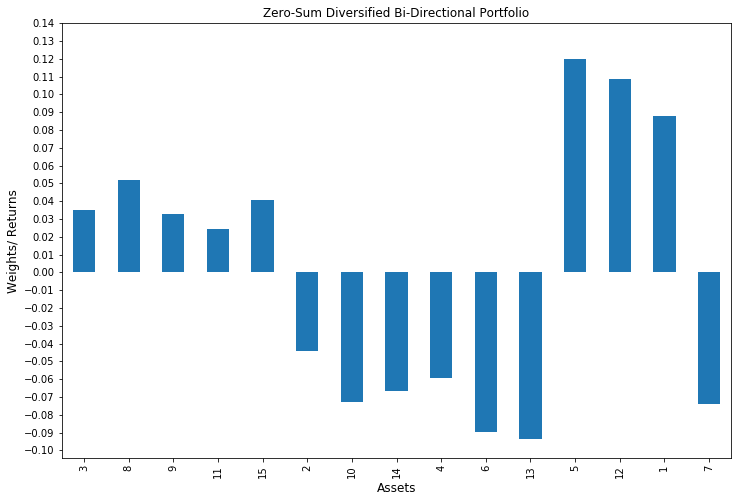


Total Allocation Sum for the Bi-Directional Portfolio: 0.000



In [18]:

grp_df["weights"] = grp_df["weights"].mul(np.sign(grp_df["Average Returns"]))
positive_sum = grp_df[grp_df["weights"] > 0].weights.sum()
negative_sum = grp_df[grp_df["weights"] <= 0].weights.sum() * -1
grp_df["weights"] = grp_df["weights"].apply(lambda x: x / positive_sum if x > 0 else x/negative_sum )
grp_df["weights"] = grp_df["weights"].mul(0.5) # To ensure we have 50/50 balance in both directions

grp_df["weights"].plot.bar(figsize=(12,8))
plt.title("Zero-Sum Diversified Bi-Directional Portfolio")
plt.ylabel("Weights/ Returns", fontsize=12)
plt.yticks(np.arange(-0.1, 0.15, step = 0.01))
plt.xlabel("Assets", fontsize=12)
plt.show()

print("\nTotal Allocation Sum for the Bi-Directional Portfolio: {0:.3f}\n".format((grp_df["weights"].sum())))

**Note**

Assuming weightage represents our confidence in each asset (Total Probability)

    Expected Return = Probability of Earning Returns * Returns till date
    
**Note**

The expected returns may seem unusual because last group that was given the most weight contains the least expected returns.

HRP is based on correlation as an estimate, to produce diversified porfolio.

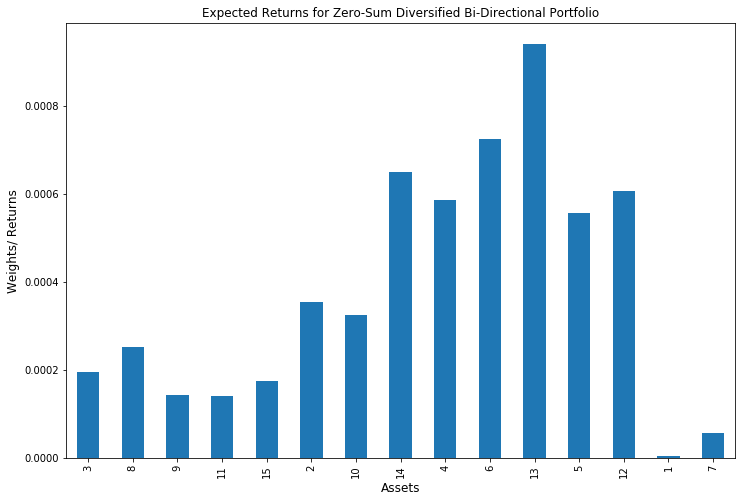

In [19]:
Er = grp_df["weights"].mul(grp_df["Average Returns"])
Er.plot.bar(figsize=(12,8))
plt.title("Expected Returns for Zero-Sum Diversified Bi-Directional Portfolio")
plt.xlabel("Assets", fontsize=12)
plt.ylabel("Expected Returns", fontsize=12)
plt.show()